<h1>Capstone project</h1>

Ok, the idea of the project is the following:

1. We take a list of all cities with more than 1 million inhabitants in north america (maybe include those in Europe and/or Australia) from Wikipedia https://en.wikipedia.org/wiki/List_of_North_American_cities_by_population (in case these are too many requests, we have to shrink down the number of cities)


2. Things become a bit tricky, we can in principle use the database of geonames at https://download.geonames.org/export/dump/ in order to get all the postal code areas of these places together with coordinates, but the names in wikipedia have to be translated into native languages (and "New York City" in Geonames is "New York").


3. We explore all these areas in Foursquare - the name conversion problem will appear again and I'm not sure yet how it can be fixed easily that the resulting areas do neither overlap - not miss too much of the cities. Well. The search for venues can be used without authentication, so it seems to be unlimited. If we get the shape of the cities, we can generate a hexagonal grid and get all the values. If there are issues with missing coordinates we can replace this by a triangular grid and triangulate all the venues.


4. The idea then is to generate a kind of fingerprint of each city by histograms and other graphs. E.g. the density of restaurants depending on the distance to the center. Of course, another problem arises here which is that some cities might have different number of "centers", but this might be given in the fingerprint. And sure, distances are related to a certain metric which is related to topology, infrastructure, no-go areas and so on. The different centers can be found using k-means and categorized to small, medium, large.


5. Maybe a higher-dimensional version of k-means can be helpful to compare and cluster all the cities


6. What are the differences between the cities? Is there a way to order them according to some dynamics (which shows their future classes with certain probabilities?)


7. Can we learn from those for their future evolution? (Of course, additional information on all levels would be quite helpful to get a better ordering, but this is only a small project ;-) e.g. fingerprints of areas could be correlated to crime rates and types)


8. Which areas need more restaurants, hotels, cafes, what so ever? This information is important for companies to know where to invest or for politicians to get an idea how the cities may develop due to certain decisions,...

<h1 align=center><font size = 5>Compare the largest western cities</font></h1>

## Introduction

...

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

As a first step, dependencies should be resolved.

In [1]:
#import numpy as np # library to handle data in a vectorized manner
#
import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#
import json # library to handle JSON files
#
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
import geopandas as gpd

#
from bs4 import BeautifulSoup
import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
#
## Matplotlib and associated plotting modules
#import matplotlib.cm as cm
#import matplotlib.colors as colors
#
## import k-means from clustering stage
#from sklearn.cluster import KMeans
#
##!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library
#

from shapely import geometry # create polygonal shapes

print('Libraries imported.')

Libraries imported.


## Download and Explore Dataset

Download data about the largest cities in North America and Europe from wikipedia

In [62]:
def getLargestCities(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "lxml")
    # get relevant table
    table = soup.find(class_="wikitable")
    
    # get all rows
    rows = table.findChildren(['tr'])

    # get the headers
    cols=[]
    headers = rows[0].findChildren('th')
    for header in headers:
        cols.append(header.get_text(strip=True))
    
    cities=[]

    for row in rows:
        city = []
        cells = row.findChildren('td')
        for cell in cells:
            city.append(cell.get_text(strip=True))
            
        cities.append(city)

    df = pd.DataFrame(cities,columns=cols)
        
    return df


After catching data, it has to be cleaned.

In [79]:
def cleanCityData(df):
    # drop first row
    df.dropna(axis=0,inplace=True)

    if 'Officialpopulation' in df.columns: df.rename(columns={"Officialpopulation": "Population"},inplace=True)
    # remove the references in the population cells
    df["Population"]=df["Population"].apply(lambda x: x.split('[')[0])
    # remove the references in the year cells
    if 'Year' in df.columns: df["Year"]=df["Year"].apply(lambda x: x.split('[')[0])
    # rewrite the index
    df=df.reset_index(drop=True)
    # convert population to integer
    df["Population"]=df["Population"].str.replace(",","").astype("int")
    df["City"]=df["City"].str.split("[").str[0]
    return df

#    df = df[(df.Country=='Canada') | (df.Country=='United States')].reset_index(drop=True)


In [90]:
def relevantCityData(df):
    # take only relevant information for cities that have more than 1 million inhabitants
    df=df[df["Population"]>1000000][["City","Country","Population"]].reset_index(drop=True)
    return df

Catch data and show its original shape

In [87]:
dfNA=getLargestCities("https://en.wikipedia.org/wiki/List_of_North_American_cities_by_population")
dfNA.head()

,,City,Image,Country,Population,Year
0,None,None,None,None,None,None
1,1,Mexico City,,Mexico,"8,918,653[a][3][4]",2015[b]
2,2,New York City,,United States,"8,550,405[5]",2015
3,3,Los Angeles,,United States,"3,971,883[5]",2015
4,4,Toronto,,Canada,"2,826,498[c][7]",2015


In [82]:
dfE=getLargestCities("https://en.wikipedia.org/wiki/List_of_European_cities_by_population_within_city_limits")
dfE.head()

,,City,Country,Officialpopulation,Date,2011 Eurostatpopulation[1],Image,Location,Ref.
0,None,None,None,None,None,None,None,None,None
1,1,Istanbul[a],Turkey,"15,067,724",31 December 2018,,,41°00′49″N28°57′18″E﻿ / ﻿41.013611°N 28.955°E﻿...,[2]
2,2,Moscow[b],Russia,"12,615,279",1 January 2019,,,55°45′00″N37°37′00″E﻿ / ﻿55.75°N 37.616667°E﻿ ...,[3]
3,3,London,United Kingdom,"9,126,366",31 December 2018,"8,173,941",,51°30′26″N0°07′39″W﻿ / ﻿51.507222°N 0.1275°W﻿ ...,[4]
4,4,Saint Petersburg,Russia,"5,383,890",1 January 2019,,,59°57′N30°18′E﻿ / ﻿59.95°N 30.3°E﻿ /59.95; 30....,[5][6]


In [ ]:


But then, data is not always shaped the same way, so the best is to reduce the dataset to US and Canada. A similar problem appears with australian data, european data is fine. This is due to the fact how data is stored in OSM an we are going to use the OSM data to get the polygonal shapes of the cities later on

Show the cleaned data. There is still a second "index" column and columns for image and year, data, location, ref that are not important for us

In [88]:
dfNA=cleanCityData(dfNA)
dfNA.head()

,,City,Image,Country,Population,Year
0,1,Mexico City,,Mexico,8918653,2015
1,2,New York City,,United States,8550405,2015
2,3,Los Angeles,,United States,3971883,2015
3,4,Toronto,,Canada,2826498,2015
4,5,Chicago,,United States,2720546,2015


In [89]:
dfE=cleanCityData(dfE)
dfE.head()

,,City,Country,Population,Date,2011 Eurostatpopulation[1],Image,Location,Ref.
0,1,Istanbul,Turkey,15067724,31 December 2018,,,41°00′49″N28°57′18″E﻿ / ﻿41.013611°N 28.955°E﻿...,[2]
1,2,Moscow,Russia,12615279,1 January 2019,,,55°45′00″N37°37′00″E﻿ / ﻿55.75°N 37.616667°E﻿ ...,[3]
2,3,London,United Kingdom,9126366,31 December 2018,"8,173,941",,51°30′26″N0°07′39″W﻿ / ﻿51.507222°N 0.1275°W﻿ ...,[4]
3,4,Saint Petersburg,Russia,5383890,1 January 2019,,,59°57′N30°18′E﻿ / ﻿59.95°N 30.3°E﻿ /59.95; 30....,[5][6]
4,5,Berlin,Germany,3748148,31 December 2018,"3,460,725",,52°31′00″N13°23′00″E﻿ / ﻿52.516667°N 13.383333...,[7]


In [91]:
dfNA=relevantCityData(dfNA)
dfNA.head()

,City,Country,Population
0,Mexico City,Mexico,8918653
1,New York City,United States,8550405
2,Los Angeles,United States,3971883
3,Toronto,Canada,2826498
4,Chicago,United States,2720546


In [92]:
dfE=relevantCityData(dfE)
dfE.head()

,City,Country,Population
0,Istanbul,Turkey,15067724
1,Moscow,Russia,12615279
2,London,United Kingdom,9126366
3,Saint Petersburg,Russia,5383890
4,Berlin,Germany,3748148


Later on, we are going to use the OSM data to get the polygonal shapes of the cities. Unfortunately this data is not stored for all cities in the expected way. Therefore, we decided to concentrate on cities in US, Canada and Europe. Problems appear for most countries south of US and Australia. In order to solve these issues, a different dataset has to be used. For south asian countries similar problems appeared but may be solved by further investigation of translations of the character encodings.

In [93]:
dfNA=dfNA[(dfNA.Country=='Canada') | (dfNA.Country=='United States')].reset_index(drop=True)

In [20]:
# now fetch the polygons for all the cities
def addPolygons(df,pos):
    df.iloc[pos]
    url = 'https://nominatim.openstreetmap.org/search.php?q={}+%2B{}&polygon_geojson=1&format=json'.format(
      df.loc[pos,"City"],
      df.loc[pos,"Country"]
    )
    print (df.loc[pos,"City"],", ",df.loc[pos,"Country"])
    return requests.get(url).json()



In [21]:
answer=addPolygons(dfNAmill,0)

New York City ,  United States


In [11]:
answer

[{'boundingbox': ['19.2726009', '19.5926009', '-99.2933416', '-98.9733416'],
  'class': 'place',
  'display_name': 'Ciudad de México, Cuauhtémoc, Ciudad de México, 06060, México',
  'geojson': {'coordinates': [-99.1333416, 19.4326009], 'type': 'Point'},
  'icon': 'https://nominatim.openstreetmap.org/images/mapicons/poi_place_city.p.20.png',
  'importance': 0.8399239324417648,
  'lat': '19.4326009',
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'lon': '-99.1333416',
  'osm_id': 62270270,
  'osm_type': 'node',
  'place_id': 248473,
  'type': 'city'},
 {'boundingbox': ['19.0482367', '19.5927572', '-99.3649242', '-98.9403028'],
  'class': 'boundary',
  'display_name': 'Ciudad de México, México',
  'geojson': {'coordinates': [[[-99.3649242, 19.2777693],
     [-99.3619219, 19.2757419],
     [-99.3561284, 19.2749894],
     [-99.3482137, 19.2739609],
     [-99.3475125, 19.2730267],
     [-99.346479, 19.2722294],
     [-99.3462968, 19.2720221],
     [-

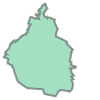

In [15]:
geometry.Polygon(answer[1]['geojson']['coordinates'][0])

In [16]:
geometry.Polygon(answer[0]['geojson']['coordinates'][0][0])

TypeError: 'float' object is not subscriptable

In [17]:
geometry.Polygon(answer[0]['geojson']['coordinates'][0])

TypeError: 'float' object is not iterable

In [ ]:


https://nominatim.openstreetmap.org/search.php?q=Warsaw+Poland&polygon_geojson=1&format=json
    https://varunpant.com/posts/how-to-create-fishnets-or-geospatial-grids/

### Europe

In [23]:
dfE=getEurope()

In [20]:
dfE.head()

,,City,Country,Officialpopulation,Date,2011 Eurostatpopulation[1],Image,Location,Ref.
0,None,None,None,None,None,None,None,None,None
1,1,Istanbul[a],Turkey,"15,067,724",31 December 2018,,,41°00′49″N28°57′18″E﻿ / ﻿41.013611°N 28.955°E﻿...,[2]
2,2,Moscow[b],Russia,"12,615,279",1 January 2019,,,55°45′00″N37°37′00″E﻿ / ﻿55.75°N 37.616667°E﻿ ...,[3]
3,3,London,United Kingdom,"9,126,366",31 December 2018,"8,173,941",,51°30′26″N0°07′39″W﻿ / ﻿51.507222°N 0.1275°W﻿ ...,[4]
4,4,Saint Petersburg,Russia,"5,383,890",1 January 2019,,,59°57′N30°18′E﻿ / ﻿59.95°N 30.3°E﻿ /59.95; 30....,[5][6]


In [24]:
def cleanEurope(df):
    # cleaning data
    df.dropna(axis=0,inplace=True)
    df=df.reset_index(drop=True)
    df.rename(columns={"Officialpopulation": "Population"},inplace=True)
    df["Population"]=df["Population"].str.replace(",","").astype("int")
    df["City"]=df["City"].str.split("[").str[0]
    return df

In [25]:
dfE=cleanEurope(dfE)

In [26]:
# take only relevant information
dfEmill=dfE[dfE["Population"]>1000000][["City","Country","Population"]].reset_index(drop=True)

In [27]:
answer=addPolygons(dfEmill,1)

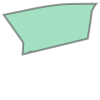

In [28]:
geometry.Polygon(answer[0]['geojson']['coordinates'][0][0])

In [29]:
answer=addPolygons(dfEmill,1)

In [30]:
answer[1]

{'boundingbox': ['55.1421745', '56.0212238', '36.8031012', '37.9674277'],
 'class': 'boundary',
 'display_name': 'Москва, Центральный федеральный округ, Россия',
 'geojson': {'coordinates': [[[[36.8031012, 55.4408329],
     [36.8113604, 55.436299],
     [36.812585, 55.4351069],
     [36.8161343, 55.4302984],
     [36.8164114, 55.429923],
     [36.8167848, 55.429926],
     [36.8191279, 55.426764],
     [36.8219237, 55.4292788],
     [36.8239519, 55.4286686],
     [36.8242994, 55.4285751],
     [36.8247808, 55.4290285],
     [36.8282363, 55.4286426],
     [36.8277826, 55.428051],
     [36.8272452, 55.4281283],
     [36.8267325, 55.4282417],
     [36.8265865, 55.4280778],
     [36.8260484, 55.4281616],
     [36.8252549, 55.427376],
     [36.8241, 55.4262054],
     [36.8226024, 55.4248663],
     [36.8211988, 55.4252289],
     [36.8216071, 55.4247244],
     [36.8224488, 55.4240415],
     [36.8230683, 55.4236753],
     [36.8237061, 55.4234926],
     [36.8245509, 55.4233368],
     [36.8244641

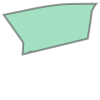

In [31]:
geometry.Polygon(answer[0]['geojson']['coordinates'][0][0])

In [33]:
crs = {'init': 'epsg:4326'}
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[geometry.Polygon(answer[1]['geojson']['coordinates'][0])])

testMap = folium.Map(location=[answer[0]["lat"], answer[0]["lon"]], zoom_start=10)

folium.GeoJson(polygon).add_to(testMap)

ValueError: A LinearRing must have at least 3 coordinate tuples

In [37]:
mexico=addPolygons(dfNAmill,0)

In [39]:
newyork=addPolygons(dfNAmill,1)

In [41]:
type(dfNAmill)

pandas.core.frame.DataFrame

In [27]:
NAPols=[addPolygons(dfNAmill,i) for i in range(len(dfNAmill))]

New York City ,  United States
Los Angeles ,  United States
Toronto ,  Canada
Chicago ,  United States
Houston ,  United States
Montreal ,  Canada
Philadelphia ,  United States
Phoenix ,  United States
San Antonio ,  United States
San Diego ,  United States
Dallas ,  United States
Calgary ,  Canada
San Jose ,  United States


In [44]:
NAPols[1]

[{'boundingbox': ['40.477399', '40.9161785', '-74.25909', '-73.7001809'],
  'class': 'place',
  'display_name': 'New York, United States of America',
  'geojson': {'coordinates': [[[[-74.25909, 40.497207],
      [-74.259028, 40.497107],
      [-74.257317, 40.494349],
      [-74.256719, 40.493299],
      [-74.254289, 40.489006],
      [-74.253313, 40.487386],
      [-74.253159, 40.487325],
      [-74.252646, 40.48712],
      [-74.249934, 40.486035],
      [-74.249897, 40.486021],
      [-74.249743, 40.48596],
      [-74.249589, 40.485898],
      [-74.248585, 40.485497],
      [-74.248261, 40.485367],
      [-74.243652, 40.483526],
      [-74.240691, 40.482342],
      [-74.237935, 40.481241],
      [-74.228153, 40.477399],
      [-74.217041, 40.479224],
      [-74.206451, 40.481015],
      [-74.200395, 40.482009],
      [-74.200342, 40.482018],
      [-74.163861, 40.488071],
      [-74.162634, 40.48829],
      [-74.160393, 40.48869],
      [-74.152069, 40.490017],
      [-74.149938, 40.4

In [92]:
EPols=[addPolygons(dfEmill,i) for i in range(len(dfEmill))]

Istanbul ,  Turkey
Moscow ,  Russia
London ,  United Kingdom
Saint Petersburg ,  Russia
Berlin ,  Germany
Kyiv ,  Ukraine
Madrid ,  Spain
Rome ,  Italy
Paris ,  France
Bucharest ,  Romania
Minsk ,  Belarus
Hamburg ,  Germany
Vienna ,  Austria
Warsaw ,  Poland
Budapest ,  Hungary
Barcelona ,  Spain
Kharkiv ,  Ukraine
Munich ,  Germany
Milan ,  Italy
Prague ,  Czech Republic
Nizhny Novgorod ,  Russia
Kazan ,  Russia
Sofia ,  Bulgaria
Birmingham ,  United Kingdom
Brussels ,  Belgium
Samara ,  Russia
Belgrade ,  Serbia
Ufa ,  Russia
Rostov-on-Don ,  Russia
Cologne ,  Germany
Voronezh ,  Russia
Perm ,  Russia
Volgograd ,  Russia
Odessa ,  Ukraine
Krasnodar ,  Russia


In [62]:
NAPols[2][1]

{'boundingbox': ['32.7969287', '34.8232693', '-118.9517221', '-117.6462406'],
 'class': 'boundary',
 'display_name': 'Los Angeles County, California, United States of America',
 'geojson': {'coordinates': [[[[-118.9517221, 33.9928639],
     [-118.9456424, 33.991997],
     [-118.9404364, 33.991457],
     [-118.9352374, 33.9917909],
     [-118.9316514, 33.9921148],
     [-118.9261994, 33.9910037],
     [-118.9192594, 33.9905076],
     [-118.9154284, 33.9904285],
     [-118.9104615, 33.9894154],
     [-118.9022275, 33.9884873],
     [-118.8972635, 33.9878092],
     [-118.8922605, 33.9874341],
     [-118.8872995, 33.987227],
     [-118.8848316, 33.986064],
     [-118.8833333, 33.9856667],
     [-118.8813956, 33.9849729],
     [-118.8759236, 33.9838268],
     [-118.8739966, 33.9833178],
     [-118.8709917, 33.9806457],
     [-118.8639959, 33.9730236],
     [-118.859281, 33.9682455],
     [-118.8568451, 33.9659735],
     [-118.8527862, 33.9625684],
     [-118.8477602, 33.9593373],
     [-118

In [28]:
[len(NAPols[i]) for i in range(len(NAPols))]

[1, 8, 7, 10, 10, 6, 10, 10, 10, 10, 10, 2, 10]

In [40]:
for data in NAPols:
    print (len(data[0]['geojson']['coordinates']))

3
8
2
3
3
4
1
39
4
1
2
2
1


In [89]:
[len(NAPols[i]) for i in range(len(NAPols))]

[2,
 1,
 8,
 7,
 10,
 10,
 1,
 6,
 3,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 2,
 2,
 10,
 1,
 4,
 10,
 10,
 6]

In [51]:
[len(EPols[i]) for i in range(len(EPols))]

[7,
 9,
 10,
 5,
 10,
 10,
 10,
 3,
 10,
 2,
 5,
 10,
 4,
 4,
 10,
 10,
 5,
 1,
 5,
 2,
 3,
 10,
 10,
 2,
 5,
 10,
 3,
 10,
 2,
 1,
 6,
 2,
 8,
 5,
 5]